In [1]:
%pip install --upgrade plotly numpy nbformat kaleido pandas 

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import plotly.express as px
import pandas as pd
from IPython.display import display, Image
from pathlib import Path

anonymizer = True
force = True

root_dir = Path.cwd()

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<fuzzy-pytorch>")
    return Path(path_str)

In [3]:
colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

In [15]:
# Data extracted from the table
use_cases = ["MNIST", "FastSurfer", "WavLM"]

data = pd.read_csv(root_dir / "perf-DL-stats.csv")

color_discrete_map = {
    "IEEE": colors_map["IEEE"],
    "Verrou": colors_map["Verrou"],
    "PRISM": colors_map["PRISM"],
}

fig = px.bar(
    data,
    x="Benchmark",
    y="Mean",
    error_y="Std",
    color="Tool",
    barmode="group",
    pattern_shape="Variant",
    log_y=True,
    color_discrete_map=color_discrete_map,
    pattern_shape_sequence=["", "/", "", "/", ""],
)
# Combine 'Verrou CESTAC' and 'Verrou SR' into a single legend group called 'Verrou'
for trace in fig.data:
    tool = trace.hovertemplate.split("Tool=")[1].split("<br>")[0]
    variant = trace.hovertemplate.split("Variant=")[1].split("<br>")[0].strip()
    if trace.name.startswith("Verrou"):
        trace.legendgroup = "Verrou"
        trace.showlegend = True
        trace.name = f"{tool} {variant}"
    elif trace.name.startswith("PRISM"):
        trace.legendgroup = "PRISM"
        trace.showlegend = True
        trace.name = f"{tool} {variant}"
    else:
        trace.legendgroup = "IEEE"
        trace.showlegend = True
        trace.name = f"{tool}"

fig.update_yaxes(exponentformat="power", minor_ticks="")
fig.update_layout(
    xaxis_title="",
    yaxis_title="Mean Runtime (sec)",
    height=600,
    width=1200,
    legend=dict(
        title="Method",
        title_side="left",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        valign="middle",
        xanchor="center",
        x=0.5,
    ),
    margin=dict(t=50, b=0, l=50, r=0),
    font=dict(size=32, family="Helvetica"),
)
fig.update_yaxes(tickfont=dict(size=24, family="Helvetica"))

# Reorder legend: PRISM UD before PRISM SR
# Find PRISM traces and swap their order in fig.data
prism_ud_idx = None
prism_sr_idx = None
for i, trace in enumerate(fig.data):
    if trace.name == "PRISM UD":
        prism_ud_idx = i
    elif trace.name == "PRISM SR":
        prism_sr_idx = i

if (
    prism_ud_idx is not None
    and prism_sr_idx is not None
    and prism_ud_idx > prism_sr_idx
):
    # Swap traces so PRISM UD comes before PRISM SR
    traces = list(fig.data)
    traces[prism_sr_idx], traces[prism_ud_idx] = (
        traces[prism_ud_idx],
        traces[prism_sr_idx],
    )
    fig.data = tuple(traces)

fig.show()

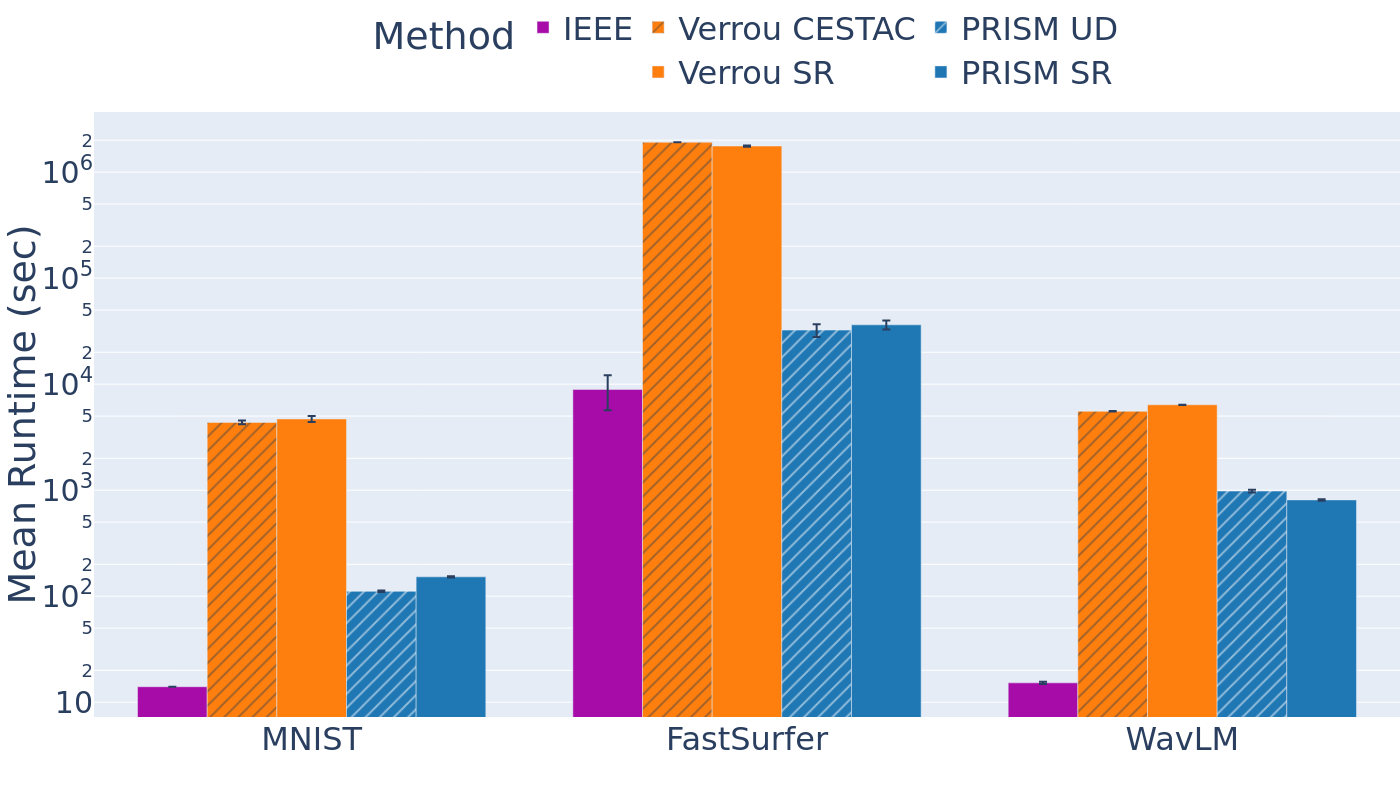

In [16]:
display(Image(fig.to_image(width=1400, height=800)))
fig.write_image(root_dir / "perf-DL-barplot.pdf", width=1400, height=800)